In [29]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

## Sample 

- **A discrete measurement of audio signal's amplitude at specifc moment in time.**
- The array y contains these samples where each element in y is a single measurement of the audio signal.

## Sampling rate  
- **How many samples are captured per second in the audio signal.**
- It is usually measured in Hertz.


In [32]:
# Load audio file
# y = time series representation of audio
# sr = sample rate, None is original sample rate.
def load_audio(file_path, duration_sec):
    y, sr = librosa.load(file_path, sr=None, duration=duration_sec)  
    y = y / np.max(np.abs(y)) # Normalize
    print("Max value:", np.max(y))
    print("Min value:", np.min(y))
    return y, sr 

file_path_music = r"C:\Users\samar\OneDrive\Documents\CS5100\Project\Sample\Hotel_california.wav" # change this
file_path_note = r"C:\Users\samar\OneDrive\Documents\CS5100\Project\Sample\c3.wav" 
y, sr = load_audio(file_path_note, duration_sec=20)  


Max value: 1.0
Min value: -0.9729298


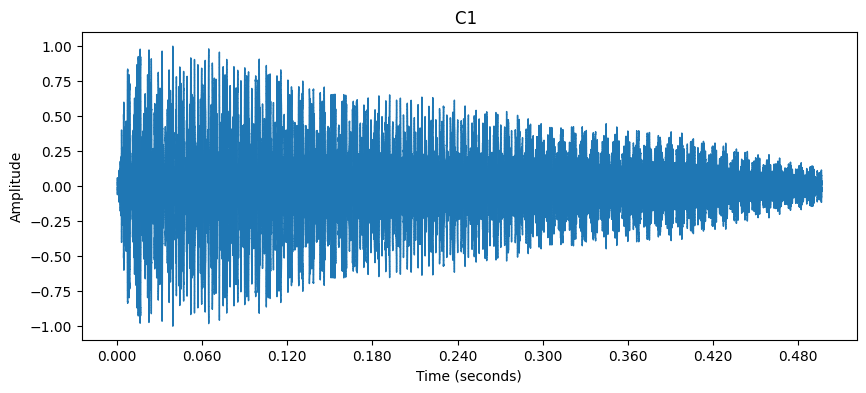

In [33]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('C1 ')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

## Fourier Transform

- **Allows us to decompose signals (sound waves) into basic building blocks—sine waves of different frequencies.**
- It transforms a **time domain** signal into a **frequency domain** representation.

### Time Domain:
- The signal is represented as a **change in amplitude over time**, like the raw audio waveform.

### Frequency Domain:
- The signal is represented by its **constituent frequencies**, showing how much of each frequency is present in the signal.

- [Interactive guide to the Fourier Transform](https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/)

### Limitation:
- The **Fourier Transform loses information about time**: it tells you **what frequencies** are present, but not **when** they occur in the signal.

---


## Short-Time Fourier Transform (STFT)

- **Extends the Fourier Transform** to handle signals whose frequency content changes over time by analyzing **small sections (windows)** of the signal at a time.
- Instead of analyzing the entire signal at once (like the Fourier Transform), **STFT divides the signal into overlapping windows** of fixed length.
- The Fourier Transform is applied to each window separately, capturing both **time** and **frequency** information.
- By sliding the window across the signal, **STFT captures how the frequency content changes over time**.

### Frequency Bins in STFT:
- **Frequencies are evenly spaced**. For example, analyzing frequencies between 0 Hz and 22 kHz, each frequency bin might be spaced by 100 Hz.
- All frequencies are treated equally, whether low or high.

### Example of Frequency Bins in STFT:
- 0 Hz, 100 Hz, 200 Hz, 300 Hz, ... up to 22,000 Hz
---


# Why Use Constant-Q Transform (CQT)?

- In **CQT**, frequencies are **logarithmically spaced**, meaning the spacing between frequency bins **gets wider as the frequencies get higher**.
- This is **how musical notes work**, as each **octave represents a doubling of frequency**.

### Example of Frequency Bins in CQT:
- 32 Hz (C1), 65 Hz (C2), 130 Hz (C3), 261 Hz (C4), 523 Hz (C5), etc.

- The spacing between low frequencies is narrow, but the spacing between high frequencies is wider.


In [34]:
# Compute Constant-Q Transform

def compute_cqt(y, sr, hop_size): #, bins_per_octave=96
    # Compute the CQT (with default bins per octave = 12)
    C = librosa.cqt(y, sr=sr, hop_length=hop_size) #, bins_per_octave=bins_per_octave
    # Convert the CQT to decibels for better visualization
    C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)
    return C_dB # A CQT spectrogram matrix, where rows correspond to frequencies and columns correspond to time frames.


cqt_spectrogram = compute_cqt(y, sr, hop_size=512)  # 512 is default.
dim = cqt_spectrogram.shape
rows, cols = dim

rows,cols # total notes, frames


c:\Users\samar\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=171
  warnings.warn(


(84, 43)

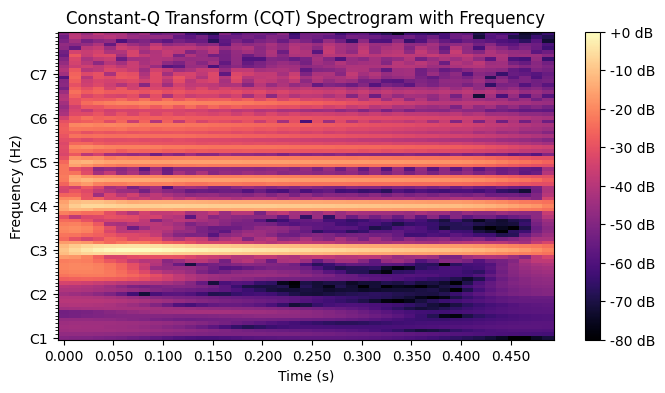

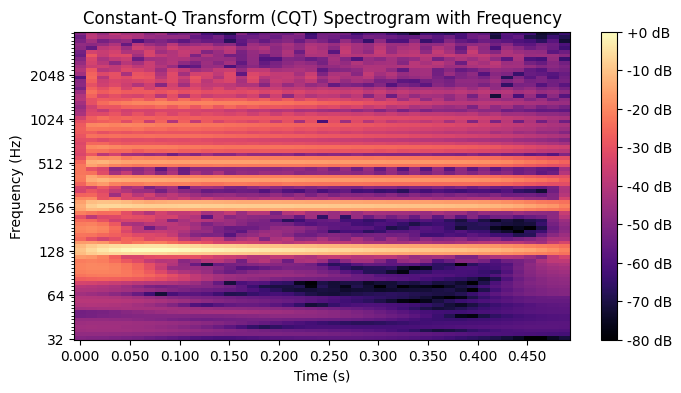

In [35]:
# Plot CQT
def plot_cqt(cqt_spectrogram, sr, yxs):
    plt.figure(figsize=(8, 4))
    # Use librosa's display functionality to plot the CQT with frequency in Hz
    librosa.display.specshow(cqt_spectrogram, sr=sr, x_axis='time', y_axis=yxs, cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q Transform (CQT) Spectrogram with Frequency')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()



plot_cqt(cqt_spectrogram, sr, yxs='cqt_note'), 
plot_cqt(cqt_spectrogram, sr, yxs='cqt_hz') 



In [36]:
min_freq, max_freq = 60, 8000  # Frequency range
num_harmonics = 10  # Number of harmonics to consider
cqt_frequencies = librosa.cqt_frequencies(n_bins=cqt_spectrogram.shape[0], fmin=min_freq, bins_per_octave=96)


In [37]:
from specmurtanalysis import specmurt_analyis
clean_spectrogram = specmurt_analyis(cqt_frequencies=cqt_frequencies, minimum_fequency=min_freq, maximum_frequency=max_freq, num_harmonics=10, bins_p_octave = 96, C_dB=cqt_spectrogram)
print(clean_spectrogram)


ValueError: could not broadcast input array from shape (84,) into shape (43,)

In [ ]:
import matplotlib.pyplot as plt
librosa.display.specshow(librosa.amplitude_to_db(clean_spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Specmurt-Enhanced CQT Spectrogram')
plt.show()

In [ ]:
mean_original = np.mean(cqt_spectrogram)
mean_specmurt = np.mean(clean_spectrogram)
print(f"Mean Amplitude of Original CQT: {mean_original:.2f}")
print(f"Mean Amplitude of Specmurt-Enhanced CQT: {mean_specmurt:.2f}")

# Compare variance, which can indicate changes in harmonic emphasis
var_original = np.var(cqt_spectrogram)
var_specmurt = np.var(clean_spectrogram)
print(f"Variance of Original CQT: {var_original:.2f}")
print(f"Variance of Specmurt-Enhanced CQT: {var_specmurt:.2f}")

In [ ]:
def reshape(spectrogram, n_timesteps):
    # Transpose CQT to match the (time_steps, features) format
    spectrogram = spectrogram.T  # Now each row is a time step, each column is a feature (frequency bin)
    # Split into sequences of n_timesteps
    X = []
    for i in range(0, len(spectrogram) - n_timesteps, n_timesteps):
        X.append(spectrogram[i:i+n_timesteps])
    X = np.array(X)
    return X

In [ ]:
n_timesteps = 50  # Number of time steps for each sequence
X = reshape(cqt_spectrogram, n_timesteps)
print(f"Reshaped data shape for LSTM input: {X.shape}")

## Labeling Data

In [ ]:
def load_raw_data(file_path):
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            start_time, end_time, chord = line.strip().split()
            labels.append((float(start_time), float(end_time), chord))
    return labels

fpath = 'Data/combined_lab_file.lab'
chord_annotations = load_raw_data(fpath)

for label in chord_annotations:
    print(f"Start: {label[0]}s, End: {label[1]}s, Chord: {label[2]}")

In [ ]:
# Aligns CQT with chord annotations by extractingg corresponding CQT frames for reach chord time interval (column in spectrogram)
def align_cqt_with_chords(cqt, sr, hop_length, chord_annotations):
    """
    Args:
        cqt: The CQT spectrogram.
        sr (int): Sampling rate of the audio.
        hop_length (int): Hop length used in CQT computation.
        chord_annotations (list of tuples): List of (start_time, end_time, chord) from the .lab file.
    
    Returns:
        List of tuples: Each tuple contains a segment of the CQT and the corresponding chord label.
    """
    fps = sr / hop_length  # Compute how many frames represent one second
    aligned_chords = []
    print(fps)
    for start_time, end_time, chord in chord_annotations:
        # Convert start and end times to CQT frame indices
        start_frame = int(np.floor(start_time * fps))
        end_frame = int(np.ceil(end_time * fps))
        # Extract the relevant CQT frames and associate them with the chord label
        aligned_chords.append((cqt[:, start_frame:end_frame], chord))
    
    return aligned_chords

aligned_chord_segments = align_cqt_with_chords(cqt_spectrogram, sr=48000, hop_length=512, chord_annotations=chord_annotations)

# Print the first aligned segment and chord
print(f"CQT Segment Shape: {aligned_chord_segments[0][0].shape}, Chord: {aligned_chord_segments[0][1]}")
